ПРИМЕР КЛАССИФИКАЦИИ ТИПОВ ДОКУМЕНТОВ С ПОМОЩЬЮ ДОРАБОТАННОЙ АРХИТЕКТУРЫ НЕЙРОСЕТИ VGG19

ТИПЫ ДОКУМЕНТОВ:
* 1 Больничные листы/Справки от врача
* 2 Трудовые книжки
* 24 Фото паспорта
* 29 Скрин приложения
* 3 Справки о доходах (2-НДФЛ, с места работы, выписка из ПФР)
* 6 Подтверждение оплаты (Чеки оплаты/перевода/справки от сторонних банков/скрины)
* 7 Платежные поручения

Данильченко Вадим

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import os, math, random
from collections import Counter

import tensorflow as tf
from keras.models import Model
from keras.layers import Conv1D, Dense, Flatten, Input, Dropout
from keras.utils import to_categorical, Sequence
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.applications import VGG19

from keras.preprocessing.image import img_to_array
from PIL import Image
import imutils

from sklearn.model_selection import train_test_split

In [2]:
# посмотрим типы документов
path = r'F:\Диск F\projects\data\классификация типов документов'
documents = [i for i in os.listdir(path) if str(i[:2]).strip().isnumeric()]
documents

['1 Больничные листыСправки от врача',
 '2 Трудовые книжки',
 '24 Фото паспорта',
 '29 Скрин приложения Хоум Кредит',
 '3 Справки о доходах (2-НДФЛ, с места работы, выписка из ПФР)',
 '6 Подтверждение оплаты (Чеки оплатыпереводасправки от сторонних банковскрины)',
 '7 Платежные поручения']

In [3]:
# создадим словарь и определим номера классов
id2doc = {k:v for k,v in enumerate(documents)}
classes = len(id2doc)
id2doc

{0: '1 Больничные листыСправки от врача',
 1: '2 Трудовые книжки',
 2: '24 Фото паспорта',
 3: '29 Скрин приложения Хоум Кредит',
 4: '3 Справки о доходах (2-НДФЛ, с места работы, выписка из ПФР)',
 5: '6 Подтверждение оплаты (Чеки оплатыпереводасправки от сторонних банковскрины)',
 6: '7 Платежные поручения'}

In [4]:
# запишем полный путь до каждого документа в переменную filenames и соответствие с номером класса в целевую переменную
filenames = []
target = []
for target_id, dirname in id2doc.items():
    tmp_path = path + '\\' + dirname
    for filename in os.listdir(tmp_path):
        if any(i in filename.lower() for i in ['jpeg', 'jpg', 'bmp', 'png']):
            target.append(target_id)
            filenames.append(tmp_path + '\\' + filename)

for i in range(2):
    print(target[i], filenames[i])
for i in range(1, 3):
    print(target[-i], filenames[-i])

0 F:\Диск F\projects\data\классификация типов документов\1 Больничные листыСправки от врача\009ea4ffd5844ed4a9194dfa936432c8.jpg
0 F:\Диск F\projects\data\классификация типов документов\1 Больничные листыСправки от врача\0c515173c4fb47fb87b3f66a5e51ad9b.jpg
6 F:\Диск F\projects\data\классификация типов документов\7 Платежные поручения\faf0d337c15c46259abc50a73ed3e2fc.jpg
6 F:\Диск F\projects\data\классификация типов документов\7 Платежные поручения\eb0fb02cc1cf4ed0adf1c01dc265ed5d.jpg


In [5]:
# преобразуем целевую переменную и разделим выборки на обучающую и тестовую
y = to_categorical(target)
x_train, x_test, y_train, y_test = train_test_split(filenames, y, test_size=0.05, random_state=777, shuffle=True)#, stratify=target)

In [6]:
img = Image.open(x_test[0])
img = imutils.resize(np.array(img), width=224, height=224)

In [7]:
# создадим генератор, который будет наращивать выборку внутри батча по миноритарным классам, 
# а также вполнять преобразования над загруженными изображениями 
# загрузка в память происходит только в рамках батча

class DataGenerator(Sequence):

    def __init__(self, batch_size, im_list, labels, data_type, mode='train'):
        self.bsz = batch_size
        self.labels = labels
        self.im_list = im_list
        self.mode = mode
        self.data_type = data_type
        self.batch_x = 0
        self.batch_y = 0
        self.batch_x_ros = 0
        self.batch_y_ros = 0
        self.idx = 0

    def __len__(self):
        return int(math.ceil(len(self.labels) / float(self.bsz)))

    # загружаем изображение по входящей ссылке на файл
    def load_image(self, im):
        # распознаем документ
        if any(i in im.lower() for i in ['jpeg', 'jpg', 'bmp', 'png']):
            img = Image.open(im)
        elif 'pdf' in im.lower():
            #             img = convert_from_path(im,
            #                                     poppler_path='./clx/poppler-0.90.1/bin',
            #                                     single_file=True)[0]

            #             pdffile = './image_classification/10. ae/00b2a607e5f04b3ab93418031e2e92df.pdf'

            doc = fitz.open(im, filetype='pdf')
            page = doc.loadPage(0)
            pix = page.getPixmap()
            img = Image.frombytes('RGB', [pix.width, pix.height], pix.samples)
            doc.close()
        else:
            raise Exception(f'unknown file type: {im}')
        return img

    # извлекаем данные с изображения
    def extract_image(self, img):

        # проверим на цветовую гамму, если не RGB, то конвертируем в RGB
        if img.mode != 'RGB':
            img = img.convert('RGB')

        return img_to_array(img.resize((img_width, img_height), 3)) / 255.


    def oversampling(self):
        cntr = Counter(np.argmax(self.batch_y, axis=1))
        max_cnt = max(cntr.values())
        #         print(max_cnt)

        y_list = np.argmax(self.batch_y, axis=1)
        y_dict_new = dict(cntr)
        x_batch_new = []
        y_list_new = []
        for i in range(len(y_list)):
            if y_dict_new[y_list[i]] < max_cnt:
                for _ in range(2):
                    x_batch_new.append(self.batch_x[i])
                    y_list_new.append(y_list[i])
                    y_dict_new[y_list[i]] += 1
            else:
                x_batch_new.append(self.batch_x[i])
                y_list_new.append(y_list[i])
                y_dict_new[y_list[i]] += 1
        return np.asarray(x_batch_new), to_categorical(np.asarray(y_list_new), num_classes=classes)

    # перемешиваем все элементы, когда находимся в режиме обучения
    def on_epoch_end(self):
#         self.indexes = range(len(self.labels)) # раскомментить, если нужно случайно выбрать
        self.indexes = list(range(len(self.labels)))
        if self.mode == 'train':
#             self.indexes = random.sample(self.indexes, k=len(self.indexes)) # раскомментить, если нужно случайно выбрать
            self.indexes = self.indexes[self.idx * self.bsz: (self.idx + 1) * self.bsz]

    # формируем батч из меток класса, который хранится в памяти
    def get_batch_labels(self, idx):
        return self.labels[idx * self.bsz: (idx + 1) * self.bsz]

    # формируем батч фичей, которые будут извлечены из изображений на диске
    def get_batch_features(self, idx):
        if self.data_type == 'image':
            return np.array([self.extract_image(self.load_image(im)) for im in self.im_list[idx * self.bsz: (1 + idx) * self.bsz]])

    def __getitem__(self, idx):
        self.idx = idx
        self.batch_x = self.get_batch_features(idx)
        self.batch_y = self.get_batch_labels(idx)
#         self.batch_x_ros, self.batch_y_ros = self.oversampling()
#         return self.batch_x_ros, self.batch_y_ros
        return self.batch_x, self.batch_y

In [8]:
# инициализируем генераторы для обучающей и валидационной выборки
batch_size = 32
img_width = 224  # Ширина изображения
img_height = 224  # Высота изображения

train_gen_image = DataGenerator(batch_size, x_train, y_train, 'image')
test_gen_image = DataGenerator(batch_size, x_test, y_test, 'image')

In [9]:
# опишем архитектуру модели
base_model = VGG19(weights='./clx/vgg19_weights_tf_dim_ordering_tf_kernels.h5')
x = base_model.get_layer('fc2').output
# x = Conv1D(16, kernel_size=5, name='conv2d_1')(x)
# x = Conv1D(32, kernel_size=3, name='conv2d_2')(x)
# x = Flatten()(x)
# x = Dense(1024, name='dense_1')(x)
# x = Dropout(0.2)(x)
x = Dense(512, name='dense_2')(x)
# x = Dropout(0.2)(x)
# x = Dense(128, name='dense_3')(x)
x = Dropout(0.1)(x)
x = Dense(32, name='dense_4')(x)
x = Dropout(0.2)(x)
out = Dense(classes, activation='softmax', name='dense_out')(x)
# for layer in base_model.layers:
#     layer.trainable = False
model = Model(base_model.input, out)

In [15]:
# скомпилируем
model.compile(loss='categorical_crossentropy',
             optimizer=Adam(learning_rate=0.0001),
             metrics=['accuracy'])
model.load_weights('./clx/model_weights_best_0.0001.hdf5')

In [16]:
# посмотрим на слои в рамках архитектуры
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [17]:
# запустим обучение модели
history = model.fit_generator(train_gen_image,
                    epochs=5,
                    validation_data=test_gen_image,
                    verbose=1,
                    # use_multiprocessing=False,
                    callbacks=ModelCheckpoint(
                                            './clx/model_weights_best_0.0001.hdf5',
                                            monitor="val_loss",
                                            save_best_only=True,
                                            save_weights_only=True,
                                            mode="auto",
                                            save_freq="epoch"),
                    # workers=4)
                    )



Epoch 1/5
48/48 [==============================] - 777s 16s/step - loss: 1.0804 - accuracy: 0.5597 - val_loss: 1.0120 - val_accuracy: 0.5375
Epoch 2/5
48/48 [==============================] - 774s 16s/step - loss: 0.9584 - accuracy: 0.6322 - val_loss: 0.7462 - val_accuracy: 0.7000
Epoch 3/5
48/48 [==============================] - 773s 16s/step - loss: 0.8385 - accuracy: 0.6823 - val_loss: 0.6531 - val_accuracy: 0.7375
Epoch 4/5
48/48 [==============================] - 775s 16s/step - loss: 0.7884 - accuracy: 0.7218 - val_loss: 0.6825 - val_accuracy: 0.7750
Epoch 5/5
48/48 [==============================] - 783s 16s/step - loss: 0.7441 - accuracy: 0.7271 - val_loss: 0.6692 - val_accuracy: 0.7375


In [18]:
# провалидируем на лучших весах
model.load_weights('./clx/model_weights_best_0.0001.hdf5')
model.evaluate_generator(test_gen_image)

[0.6530642509460449, 0.737500011920929]

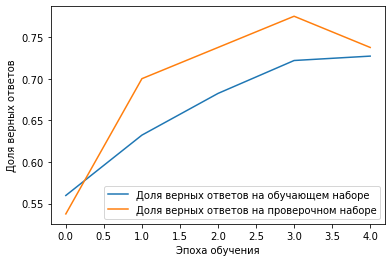

In [19]:
# Оображаем график точности обучения
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

-------------------------------------

Вывод: эксперимент показал, что подобную архитектуру можно пробовать для классификации типов документов, конечно еще стоит поработать над улучшением результатов, но в первом приближении довольно неплохо